In [10]:
import abc
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# this is an adapted version of my diffusion code
# from reactor theory so there is extra stuff

class Material(abc.ABC):

    @abc.abstractmethod
    def xs_tr(self, energy_group):
        return NotImplementedError

    @abc.abstractmethod
    def xs_abs(self, energy_group):
        return NotImplementedError

    @abc.abstractmethod
    def nu_fission(self, energy_group):
        return NotImplementedError

    @abc.abstractmethod
    def kappa_fission(self, energy_group):
        return NotImplementedError

    def diffusion_coeff(self, energy_group):
        return 1 / (3 * self.xs_tr(energy_group))

    def extrapolation_distance(self, energy_group):
        return 0.7104 / self.xs_tr(energy_group)


class OneGroupDiffusiveMaterial(Material):
    """Temporary class """
    def __init__(self, xs_total, xs_scatter0):
        self.xs_total = xs_total
        self.xs_scatter0 = xs_scatter0
        self.xs_scatter1 = 0
        
    def xs_tr(self, energy_group):
        return self.xs_total - self.xs_scatter1
    
    def xs_abs(self, energy_group):
        return self.xs_total - self.xs_scatter0
    
    def nu_fission(self, energy_group):
        return 0
    
    def kappa_fission(self, energy_group):
        return 0


class Node:

    def __init__(self, material: Material):
        self.material: Material = material

    def xs_tr(self, energy_group):
        return self.material.xs_tr(energy_group)

    def xs_abs(self, energy_group):
        return self.material.xs_abs(energy_group)

    def nu_fission(self, energy_group):
        return self.material.nu_fission(energy_group)

    def kappa_fission(self, energy_group):
        return self.material.kappa_fission(energy_group)

    def local_diffusion_coeff(self, energy_group):
        """Do not use in matrix!"""
        return self.material.diffusion_coeff(energy_group)

    def extrapolation_distance(self, energy_group):
        return self.material.extrapolation_distance(energy_group)


class Mesh:

    def __init__(
        self, materials: list[Material], material_widths: list[float], dx: float
    ):
        self.material_widths = material_widths
        self.dx = dx

        cumulative_lengths = np.cumsum(material_widths)
        for cumulative_length in cumulative_lengths:
            assert (
                cumulative_length / dx
            ).is_integer(), "Material boundaries do not line up with nodes"

        self.length = cumulative_lengths[-1]

        self.n_nodes = int(self.length / dx) + 1  # because first node is at x = 0

        # assign materials to nodes based on material widths
        # interface nodes get the material to the left
        # except for the last node, which gets the first material
        material_indices = np.searchsorted(
            cumulative_lengths, np.arange(self.n_nodes - 1) * dx, side="left"
        )
        material_indices = np.append(material_indices, -1)
        self.nodes = [Node(materials[i]) for i in material_indices]

    def average_diffusion_coeff(self, idx_half, energy_group):
        """
        idx_half is an integer +- a half to represent location between nodes.
        you could reduce some potential reduce some flops by checking if left and right materials are the same.
        """
        left_node = self.nodes[int(idx_half - 0.5)]
        right_node = self.nodes[int(idx_half + 0.5)]

        d_left = left_node.local_diffusion_coeff(energy_group)
        d_right = right_node.local_diffusion_coeff(energy_group)

        return (2 * d_left * d_right) / (d_left + d_right)

    def alpha(self, idx, energy_group):
        return self.average_diffusion_coeff(idx - 0.5, energy_group) / self.dx

    def beta(self, idx, energy_group):
        return (
            self.nodes[idx].xs_abs(energy_group) * self.dx
            + self.alpha(idx, energy_group)
            + self.gamma(idx, energy_group)
        )

    def gamma(self, idx, energy_group):
        return self.average_diffusion_coeff(idx + 0.5, energy_group) / self.dx

    def beta_reflecting_left(self, energy_group):
        return self.nodes[0].xs_abs(
            energy_group
        ) * self.dx + self.gamma_reflecting_left(energy_group)

    def gamma_reflecting_left(self, energy_group):
        return self.gamma(0, energy_group)

    def alpha_reflecting_right(self, energy_group):
        return self.alpha(-1, energy_group)

    def beta_reflecting_right(self, energy_group):
        return self.nodes[-1].xs_abs(
            energy_group
        ) * self.dx + self.alpha_reflecting_right(energy_group)
        
    def beta_vacuum_left(self, energy_group):
        first_node = self.nodes[0]
        alpha_vacuum = first_node.local_diffusion_coeff(energy_group) / (
            self.dx / 2 + first_node.extrapolation_distance(energy_group)
        )
        return (
            first_node.xs_abs(energy_group) * self.dx
            + alpha_vacuum
            + self.gamma_reflecting_left(energy_group)
        )
        
    def gamma_vacuum_left(self, energy_group):
        return self.gamma(0, energy_group)

    def alpha_vacuum_right(self, energy_group):
        return self.alpha(-1, energy_group)

    def beta_vacuum_right(self, energy_group):
        last_node = self.nodes[-1]
        gamma_vacuum = last_node.local_diffusion_coeff(energy_group) / (
            self.dx / 2 + last_node.extrapolation_distance(energy_group)
        )
        return (
            last_node.xs_abs(energy_group) * self.dx
            + self.alpha_vacuum_right(energy_group)
            + gamma_vacuum
        )
        


class Solver:
    def __init__(self, mesh: Mesh, left_bc, right_bc, volumetric_source = 0):
        self.mesh: Mesh = mesh

        for bc in [left_bc, right_bc]:
            assert bc in ["reflecting", "vacuum"] or isinstance(bc, (int, float))
        self.left_bc = left_bc
        self.right_bc = right_bc
        self.volumetric_source = volumetric_source

        self.flux = []
        # self.flux_history = []
        # self.power_history = []
        # self.k_eff_history = []

    def make_matrix(self):
        energy_group = "Fast"

        n_nodes = self.mesh.n_nodes
        matrix = np.zeros((n_nodes, n_nodes))
        
        if self.left_bc == "reflecting":
            left_beta = self.mesh.beta_reflecting_left(energy_group)
            left_gamma = self.mesh.gamma_reflecting_left(energy_group)
        elif self.left_bc == "vacuum":
            left_beta = self.mesh.beta_vacuum_left(energy_group)
            left_gamma = self.mesh.gamma_vacuum_left(energy_group)
        else:
            left_beta = 1
            left_gamma = 0

        matrix[0, 0] = left_beta
        matrix[0, 1] = -left_gamma
        
        if self.right_bc == "reflecting":
            right_beta = self.mesh.beta_reflecting_right(energy_group)
            right_alpha = self.mesh.alpha_reflecting_right(energy_group)
        elif self.right_bc == "vacuum":
            right_beta = self.mesh.beta_vacuum_right(energy_group)
            right_alpha = self.mesh.alpha_vacuum_right(energy_group)
        else:
            right_beta = 1
            right_alpha = 0

        matrix[-1, -2] = -right_alpha
        matrix[-1, -1] = right_beta

        for i in range(1, n_nodes - 1):
            matrix[i, i - 1] = -self.mesh.alpha(i, energy_group)
            matrix[i, i] = self.mesh.beta(i, energy_group)
            matrix[i, i + 1] = -self.mesh.gamma(i, energy_group)

        return matrix

    def make_source_vector(self, fluxes):
        """TODO Two energy groups"""
        energy = "Fast"
        source = [
            (self.volumetric_source + node.nu_fission(energy) * float(flux)) * self.mesh.dx
            for node, flux in zip(self.mesh.nodes, fluxes)
        ]
        if isinstance(self.left_bc, (int, float)):
            source[0] = self.left_bc
        if isinstance(self.right_bc, (int, float)):
            source[-1] = self.right_bc
        return source

    def solve(self, max_iter=1000, tol=1e-8):
        lhs = self.make_matrix()
        # mat_inv = np.linalg.inv(lhs)

        fluxes = np.ones(self.mesh.n_nodes)
        k = 1.0
        source_vector = self.make_source_vector(fluxes)
        
        start_time = time.time()
        self.flux = np.linalg.solve(lhs, source_vector)
        self.solve_time = time.time() - start_time
        return self.flux
    
    def x_values(self):
        x_start = 0
        x_end = 100
        x = np.linspace(x_start, x_end, self.mesh.n_nodes)
        return x
    
    def plot_flux(self):
        fig, ax = plt.subplots()
        x_start = 0
        x_end = 100 # self.mesh.length
        x = np.linspace(x_start, x_end, self.mesh.n_nodes)
        
        ax.plot(x, self.flux)
        ax.set_xlabel("Position (cm)")
        ax.set_ylabel("Flux")
        
        return fig, ax
        
        ## We aren't doing power iteration yet:
        # for i in range(max_iter):
        #     previous_k = k
        #     previous_fission_source = fission_source.copy()

        #     one_over_k = 1 / k
        #     rhs = [one_over_k * fission for fission in fission_source]

        #     fluxes = np.dot(mat_inv, rhs)
        #     fission_source = self.make_source_vector(fluxes)
        #     k = previous_k * np.sum(fission_source) / np.sum(previous_fission_source)

        #     if np.abs(k - previous_k) < tol:
        #         break

        #     if i == max_iter - 1:
        #         raise ValueError("Did not converge")

        # # Normalize flux
        # calculated_power = (
        #     2  # reflected reactor
        #     * self.mesh.dx
        #     * np.sum(
        #         [
        #             node.kappa_fission("Fast") * flux  # TODO Two energy groups
        #             for node, flux in zip(self.mesh.nodes, fluxes)
        #         ]
        #     )
        # )  # W/cm2
        # scaling_factor = self.set_power / calculated_power
        # fluxes *= scaling_factor

        # # Calculate actual power
        # nodal_power = [
        #     node.kappa_fission("Fast") * flux  # TODO Two energy groups
        #     for node, flux in zip(self.mesh.nodes, fluxes)
        # ]
        # assert np.isclose(
        #     2 * self.mesh.dx * np.sum(nodal_power), self.set_power
        # ), "Power not conserved"

        # return k, fluxes, nodal_power
        
    def current(self):
        scalar_flux_derivative = np.gradient(self.flux, self.mesh.dx)
        diffusion_coeffs = [node.local_diffusion_coeff("Fast") for node in self.mesh.nodes]
        current = [-d * df for d, df in zip(diffusion_coeffs, scalar_flux_derivative)]
        return current
        
def test_case(left_bc, right_bc, volumetric_source, sigma_t, sigma_s, number_of_cells):
    material = OneGroupDiffusiveMaterial(xs_total=sigma_t, xs_scatter0=sigma_s)
    mesh = Mesh([material], 100, 100/number_of_cells)
    solver = Solver(mesh=mesh, left_bc=left_bc, right_bc=right_bc, volumetric_source=volumetric_source)
    flux = solver.solve()
    return solver


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Position (cm)', ylabel='Flux'>)

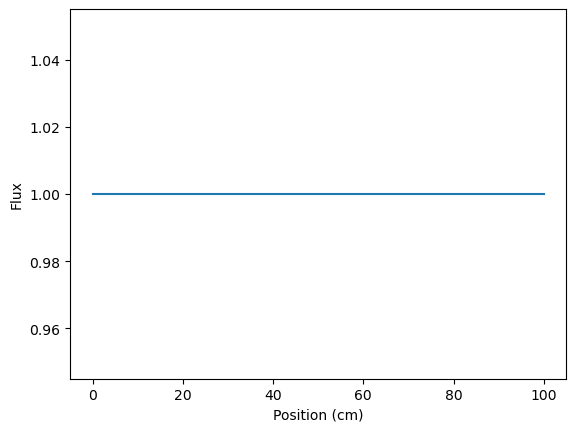

In [12]:
prob1 = test_case(left_bc="reflecting", right_bc="reflecting", volumetric_source=1, sigma_t=1, sigma_s=0, number_of_cells=100)
prob1.plot_flux()

Text(0.5, 1.0, 'Diffusion solve time Problem 1')

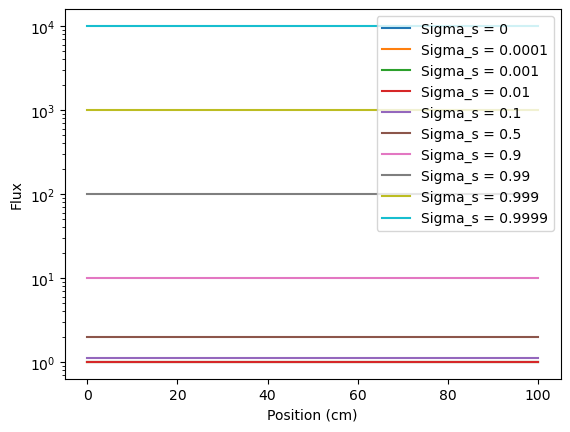

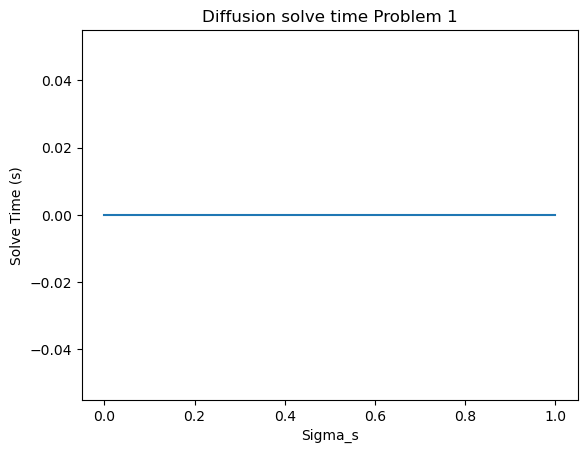

In [19]:
# prob 1 all sigma scatters
fig, ax = plt.subplots()
fig_time, ax_time = plt.subplots()
sigma_scatters = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.9, 0.99, 0.999, 0.9999]
# sigma scatter = 1 is not possible because singular matrix

solve_times = []
for sigma_s in sigma_scatters:
    prob1 = test_case(left_bc="reflecting", right_bc="reflecting", volumetric_source=1, sigma_t=1, sigma_s=sigma_s, number_of_cells=100)
    
    ax.plot(prob1.x_values(), prob1.flux, label=f"Sigma_s = {sigma_s}")
    solve_times.append(prob1.solve_time)
    
ax.set_xlabel("Position (cm)")
ax.set_ylabel("Flux")
ax.set_yscale("log")
ax.legend()

ax_time.plot(sigma_scatters, solve_times)
ax_time.set_xlabel("Sigma_s")
ax_time.set_ylabel("Solve Time (s)")
ax_time.set_title("Diffusion solve time Problem 1")

Text(0.5, 1.0, 'Current 10240 cells')

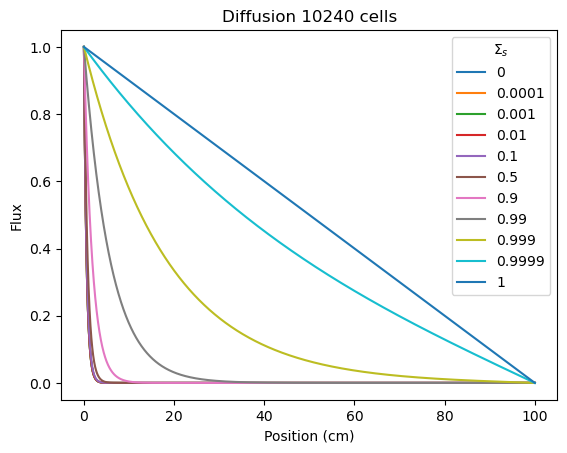

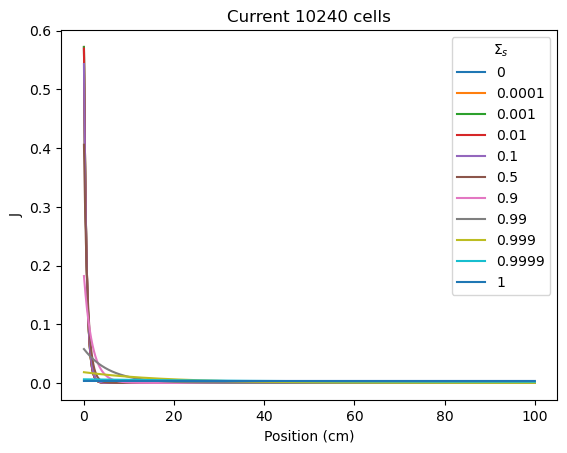

In [31]:
# prob 2 without varying mesh size
fig, ax = plt.subplots()
fig_current, ax_current = plt.subplots()
sigma_scatters = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.9, 0.99, 0.999, 0.9999, 1]
number_of_cells = 10240
for sigma_s in sigma_scatters:
    prob2 = test_case(
        left_bc=1,
        right_bc=0,
        volumetric_source=0,
        sigma_t=1,
        sigma_s=sigma_s,
        number_of_cells=number_of_cells,
    )

    ax.plot(prob2.x_values(), prob2.flux, label=f"{sigma_s}")
    
    ax_current.plot(prob2.x_values(), prob2.current(), label=f"{sigma_s}")

ax.set_xlabel("Position (cm)")
ax.set_ylabel("Flux")
# ax.set_yscale("log")
ax.legend(title=r"$\Sigma_s$")
ax.set_title(f"Diffusion {number_of_cells} cells")

ax_current.set_xlabel("Position (cm)")
ax_current.set_ylabel("J")
ax_current.legend(title=r"$\Sigma_s$")
ax_current.set_title(f"Current {number_of_cells} cells")

Text(0.5, 1.0, 'Problem 3: Diffusion Current 10240 cells')

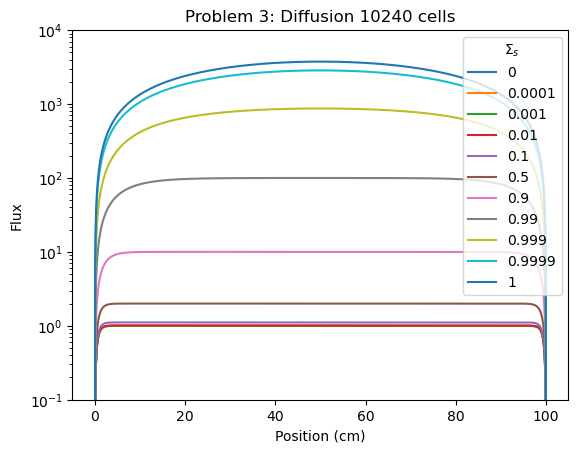

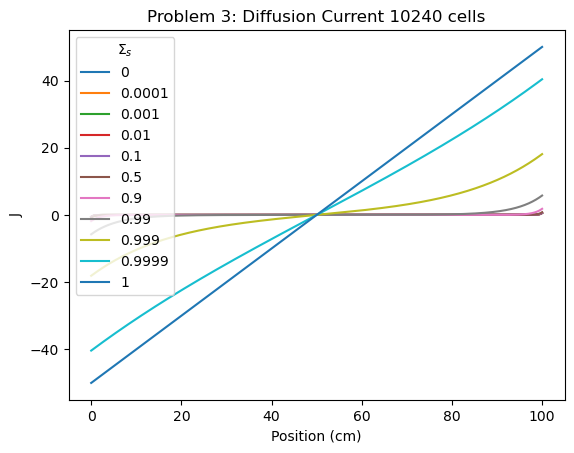

In [37]:
# prob 3 without varying mesh size
fig, ax = plt.subplots()
fig_current, ax_current = plt.subplots()
number_of_cells = 10240
sigma_scatters = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.9, 0.99, 0.999, 0.9999, 1]

for sigma_s in sigma_scatters:
    prob3 = test_case(
        left_bc=0,
        right_bc=0,
        volumetric_source=1,
        sigma_t=1,
        sigma_s=sigma_s,
        number_of_cells=number_of_cells,
    )

    ax.plot(prob3.x_values(), prob3.flux, label=f"{sigma_s}")
    ax_current.plot(prob3.x_values(), prob3.current(), label=f"{sigma_s}")
    
ax.set_xlabel("Position (cm)")
ax.set_ylabel("Flux")
ax.set_yscale("log")
ax.legend(title=r"$\Sigma_s$")
ax.set_title(f"Problem 3: Diffusion {number_of_cells} cells")
ax.set_ylim(1e-1, 1e4)

ax_current.set_xlabel("Position (cm)")
ax_current.set_ylabel("J")
ax_current.legend(title=r"$\Sigma_s$")
ax_current.set_title(f"Problem 3: Diffusion Current {number_of_cells} cells")